# Example 2:

In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# Step 1: load fMRI dataset

In [3]:
homedir = split(os.getcwd())[0]

datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

datafn = join(datadir,'nsdflocexampledataset.mat')

print(f'directory to save example dataset:\n{datadir}')

directory to save example dataset:
/Volumes/T7/research/projects/GLMsingle/examples/data


In [4]:
# Data comes from subject1, fLoc session from NSD dataset.
# https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/g42tm/download'
    
    # download the .mat file to the specified director
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

# get mask defining liberal visual cortex ROI
#ROI = X['ROI']

In [5]:
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    temp = copy.deepcopy(X['data'][0,r]) # use deepcopy to avoid editing X by reference
    data.append(temp)
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(52, 81, 42, 234)


data -> consists of several runs of 4D volume files (x,y,z,t) where (t)ime is the 4th dimention. In this example data consists of only a single slice and has been prepared with a TR = 1s

ROI -> manually defined region in the occipital cortex. It is a binary matrix where (x,y,z) = 1 corresponds to the cortical area that responded to visual stimuli used in the NSD project.

# visualize data and design matrix

In [6]:
print(f'data has {len(data)} runs')
print(f'shape of data from each run is: {data[0].shape}')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)')
print(f'n = {data[0].shape[3]} TRs per run')
print(f'type of data is: {type(data[0][0,0,0,0])}')

data has 4 runs
shape of data from each run is: (52, 81, 42, 234)
XYZ dimensionality is: (52, 81, 42) (one slice only)
n = 234 TRs per run
type of data is: <class 'numpy.float32'>


Text(0, 0.5, 'time (TR)')

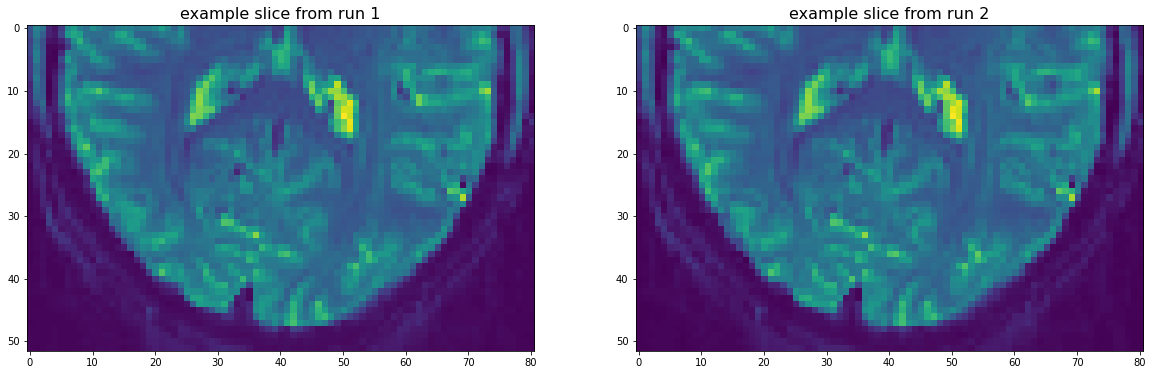

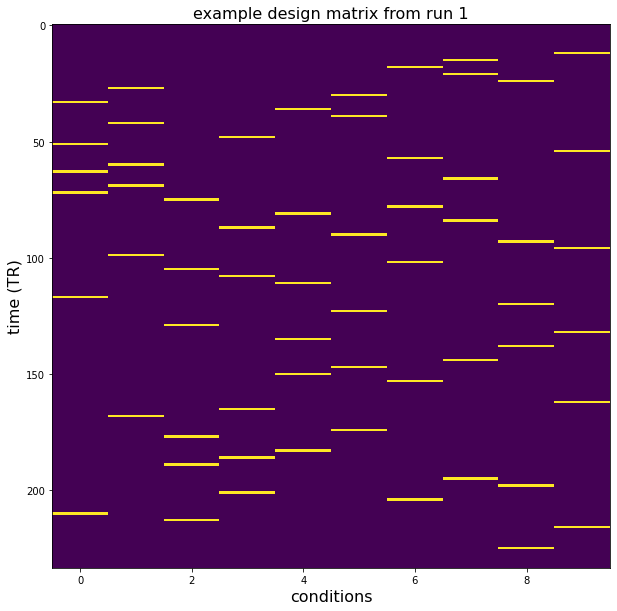

In [7]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,20,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][:,:,20,0])
plt.title('example slice from run 2',fontsize=16)

plt.figure(figsize=(10,10))
plt.imshow(design[0],aspect='auto',interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16)

design -> Each run has a corresponding design matrix where each column
describes a single condition (conditions are repeated across runs). 
Each design matrix is binary with 1 specfing the time (TR) when the stimulus 
is presented on the screen.

In this NSD fLOC session there were 10 distinct images shown and hence
there are 10 predictor columns/conditions. Notice that the rectangles
are pseudo randomized and they indicate when the presentaion of each
image occurs. Details of the stimulus are described here
https://github.com/VPNL/fLoc

# Step 2: Run baseline GLM (canonical HRF and no optimizations) using GLMsingle

In [8]:
outputdir = join(homedir,'examples','example2outputs')

opt = dict()

# turn off optimizations
opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [0,0,0,0]

# For the purpose of this example we will keep the relevant outputs in memory
opt['wantmemoryoutputs'] = [1,1,0,0]

start_time = time.time()

# create GLM_single object
gst_assumehrf = GLM_single(opt)

pprint(gst_assumehrf.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1625164279.220363,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [0, 0, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


- Outputs and figures will be stored in a folder (you can specify it's name 
as the 5th output to GLMestimatesingletrial.) Model estimates can be also
saved to the results variable which is the only output of 
GLMestimatesingletrial

- Optional parameters below can be assigned to a strucutre i.e
opt = struct('wantlibrary',1,'wantglmdenoise',1); Options are the 6th  
input to GLMestimatesingletrial.

- DEFAULT OPTIONS:

    - wantlibrary = 1 -> Fit HRF to each voxel
    - wantglmdenoise = 1 -> Use GLMdenoise
    - wantfracridge = 1  -> Use ridge regression to improve beta estimates
    - chunknum = 50000 -> is the number of voxels that we will process at the same time. For setups with lower memory deacrease this number.
    - wantmemoryoutputs is a logical vector [A B C D] indicating which of the four model types to return in the output <results>. The user must be careful with this, as large datasets can require a lot of RAM. If you
do not request the various model types, they will be cleared from 
memory (but still potentially saved to disk). Default: [0 0 0 1] which means return only the final type-D model.

    - wantfileoutputs is a logical vector [A B C D] indicating which of the four model types to save to disk (assuming that they are computed).
        - A = 0/1 for saving the results of the ONOFF model
        - B = 0/1 for saving the results of the FITHRF model
        - C = 0/1 for saving the results of the FITHRF_GLMdenoise model
        - D = 0/1 for saving the results of the FITHRF_GLMdenoise_RR model
        - Default: [1 1 1 1] which means save all computed results to disk.

    - numpcstotry (optional) is a non-negative integer indicating the maximum
number of PCs to enter into the model. Default: 10.

    - fracs (optional) is a vector of fractions that are greater than 0
and less than or equal to 1. We automatically sort in descending 
order and ensure the fractions are unique. These fractions indicate 
the regularization levels to evaluate using fractional ridge 
regression (fracridge) and cross-validation. Default: 
fliplr(.05:.05:1). A special case is when <fracs> is specified as a 
single scalar value. In this case, cross-validation is NOT performed 
for the type-D model, and we instead blindly use the supplied 
fractional value for the type-D model.

In [9]:
# run GLMsingle, fitting the baseline GLM
results_assumehrf = gst_assumehrf.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.4527941629023875 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 4/4 [00:40<00:00, 10.13s/it]


*** All model types done ***

*** return model types in results ***

elapsed time:  00:02:12


# Step 3: Visualize baseline GLM outputs

In [10]:
R2 = results_assumehrf['typea']['onoffR2'].reshape((52, 81, 42))


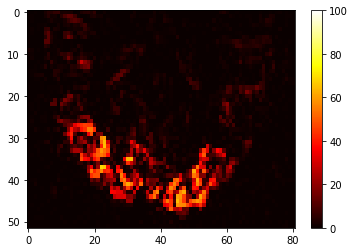

In [11]:
plt.imshow(R2[:,:,20],aspect='auto',clim=(0,100),cmap='hot')
plt.colorbar()

# Step 4: Run GLMsingle with optimizations (library of HRFs, GLMdenoise, fractional ridge regression)

In [12]:
data = []
design = []

for r in range(len(X['data'][0])):
    temp = copy.deepcopy(X['data'][0,r])
    data.append(temp[:,:])
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(52, 81, 42, 234)


In [13]:

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

start_time = time.time()
gst_glmsingle = GLM_single(opt)

pprint(gst_glmsingle.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1625164279.220363,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /Volumes/T7/research/projects/GLMsingle/examples/example2outputs/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.4527941629023875 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 4/4 [07:06<00:00, 106.59s/it]



*** Saving results to /Volumes/T7/research/projects/GLMsingle/examples/example2outputs/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]


*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 4/4 [01:04<00:00, 16.15s/it]



*** Saving results to /Volumes/T7/research/projects/GLMsingle/examples/example2outputs/TYPEC_FITHRF_GLMDENOISE.npy. ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 4/4 [13:48<00:00, 207.16s/it]



*** Saving results to /Volumes/T7/research/projects/GLMsingle/examples/example2outputs/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

elapsed time:  00:33:13


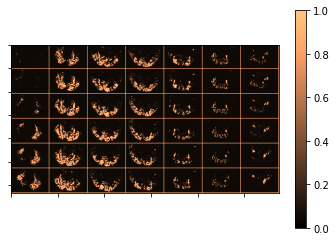

In [14]:
# run GLMsingle
results_glmsingle = gst_glmsingle.fit(
   design,
   data,
   stimdur,
   tr,
   outputdir=outputdir)

elapsed_time = time.time() - start_time
print(
    'elapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)


# Step 5: gather different beta versions, compare split-half reliability

In [15]:
# todo: modify to load data if exists already
models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd']
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [16]:
# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# compute a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)
corder[:3]

array([9, 7, 6])

In [93]:
repindices = []

for p in range(designALL.shape[1]):
    temp = np.argwhere(corder==p)[:,0]
    if len(temp) >= 2:
        repindices.append(temp)

repindices = np.vstack(np.array(repindices)).T      

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')
print(f'there are {repindices.shape[0]} instances of each repeated condition')

there are 10 repeated conditions in the experiment
there are 24 instances of each repeated condition


In [94]:
FFA_roi = X['floc'].item()[0] == 2          # for FFA-1
earlyvis_roi = X['visual'].item()[0] == 1   # for V1

In [95]:
vox_reliabilities = []
modelnames = list(models.keys())
n_cond = repindices.shape[1]

# number of times to shuffle the presentation order of the betas within each condition
n_permutations = 25

for m in range(len(modelnames)):
    print(modelnames[m])
    time.sleep(1)
    
    # for each GLM under comparison, arrange the betas by (X,Y,Z,repeats,conditions)
    betas = models[modelnames[m]][:,:,:,repindices]
    x,y,z = betas.shape[:3] 
    
    # create output volume for voxel reliability scores
    rels = np.full((x,y,z),np.nan)
    
    # iterate through voxels...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # process only if within ROIs of interest
                if FFA_roi[xx,yy,zz] or earlyvis_roi[xx,yy,zz]: 
                    
                    # for this voxel, get beta matrix of (repeats,conditions)
                    vox_data = betas[xx,yy,zz]
                    vox_perm = np.full((n_permutations,),np.nan) # for results of permutations
                    
                    for p in range(n_permutations):
                        vox_data_shuffle = copy.deepcopy(vox_data)
                        
                        # shuffle the betas within each column (condition)
                        for c in range(n_cond):
                            np.random.shuffle(vox_data_shuffle[:,c])
                        
                        # average odd and even betas after shuffling
                        even_data = np.nanmean(vox_data_shuffle[::2],axis=0)
                        odd_data = np.nanmean(vox_data_shuffle[1::2],axis=0)
                        
                        # compute split-half reliability and store
                        r = np.corrcoef(even_data,odd_data)[1,0]
                        vox_perm[p] = r
                        
                    rels[xx,yy,zz] = np.nanmean(vox_perm)
          
    vox_reliabilities.append(rels)


assumehrf


100%|██████████| 52/52 [00:14<00:00,  3.53it/s] 


fithrf


100%|██████████| 52/52 [00:08<00:00,  6.05it/s] 


fithrf_glmdenoise


100%|██████████| 52/52 [00:08<00:00,  5.94it/s] 


fithrf_glmdenoise_rr


100%|██████████| 52/52 [00:08<00:00,  6.34it/s] 


[[0.44059086 0.10459465]
 [0.51559242 0.21801747]
 [0.50090019 0.16236234]
 [0.60032752 0.23900993]]


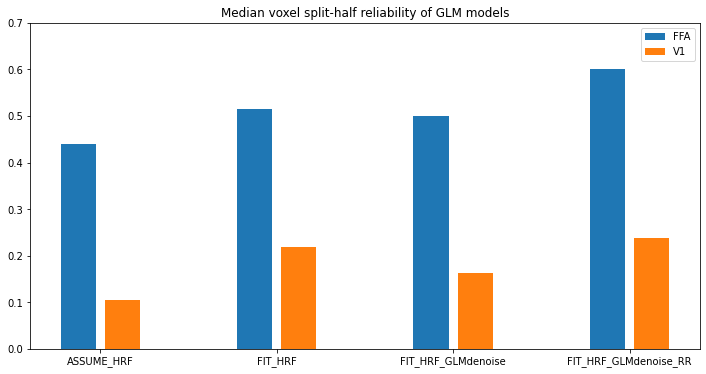

In [96]:
comparison = []
for vr in vox_reliabilities:
    comparison.append([np.nanmedian(vr[FFA_roi]), np.nanmedian(vr[earlyvis_roi])])
comparison = np.vstack(comparison)

plt.figure(figsize=(12,6))
plt.bar(np.arange(len(comparison[:,0]))-0.125,comparison[:,0],width=0.2)
plt.bar(np.arange(len(comparison[:,1]))+0.125,comparison[:,1],width=0.2)
plt.ylim([0,0.7])
print(comparison)
plt.legend(['FFA','V1'])
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUME_HRF', 'FIT_HRF', 'FIT_HRF_GLMdenoise', 'FIT_HRF_GLMdenoise_RR']));


In [37]:
a = np.squeeze(vox_reliabilities[3])
a[ROI!=1] = np.nan

plt.imshow(X['data'][0,r][:,:,0,0],cmap='gray')
plt.imshow(a,clim=(0,0.5),cmap='hot')

NameError: name 'ROI' is not defined